In [1]:
# !pip install numpy num2words nltk pandas Observations gensim
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# !pip install -U textblob
# !python -m textblob.download_corpora

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from num2words import num2words
from collections import Counter
from scipy import spatial
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.special import gammaln
from collections import Counter
from textblob import TextBlob

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import gensim
import pickle
import imp
import lda2
import scipy
import operator
import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
import pickle

In [3]:
def convert_numbers(k):
    for i in range(len(k)):
        try:
            num2words(int(k[i]))
            k[i] = " "
        except:
            pass
    return k

def get_cosine(a, b):
    return 1 - spatial.distance.cosine(a, b)

def preprocess(pd):
    pd = pd.str.lower()
    pd = pd.str.replace('[{}]'.format('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n\t'), ' ')
    pd = pd.apply(lambda x: [w for w in w_tokenizer.tokenize(x)])
    pd = pd.apply(lambda x: convert_numbers(x))
    pd = pd.str.join(' ')
    
    pd = pd.apply(lambda x: [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(x)])    
    pd = pd.apply(lambda x: [item for item in x if item not in stop_words])
    return pd

def processReviews(reviews, window=5, MAX_VOCAB_SIZE=1000):
    vectorizer = CountVectorizer(analyzer="word",tokenizer=None)
    train_data_features = vectorizer.fit_transform(reviews)
    words = vectorizer.get_feature_names()
    vocabulary = dict(zip(words,np.arange(len(words))))
    inv_vocabulary = dict(zip(np.arange(len(words)),words))
    wordOccurenceMatrix = train_data_features.toarray()
    return wordOccurenceMatrix, vocabulary, words

In [4]:
def coherence_score(X, topic_sentiment_df):
    X[X>1] = 1    
    totalcnt = len(topic_sentiment_df)
    total = 0
    for allwords in topic_sentiment_df:
        for word1 in allwords:
            for word2 in allwords:
                if word1 != word2:
                    ind1 = vocabulary[word1]
                    ind2 = vocabulary[word2]
                    total += np.log((np.matmul(X[:,ind1].T, X[:,ind2]) + 1.0)/np.sum(X[:,ind2]))
    return total/(2*totalcnt)

def kl_score(pk,qk):
    return (scipy.stats.entropy(pk,qk)*.5 + scipy.stats.entropy(qk,pk)*.5)

def get_hscore(dt_distribution, X, k):
    testlen = X.shape[0]
    all_kl_scores = np.zeros((testlen, testlen))
    for i in range(testlen-1):
        for j in range(i+1,testlen):
            score = kl_score(dt_distribution[i],dt_distribution[j])
            all_kl_scores[i,j] = score
            all_kl_scores[j,i] = score

    dt = np.zeros((X.shape[0], k))

    for i in range(X.shape[0]):
        dt[i, dt_distribution[i].argmax()]=1

    intradist = 0
    for i in range(k):
        cnt = dt[:,i].sum()
        tmp = np.outer(dt[:,i],dt[:,i])
        tmp = tmp * all_kl_scores
        intradist += tmp.sum()*1.0/(cnt*(cnt-1))
    intradist = intradist/k
    

    interdist = 0
    for i in range(k):
       for j in range(k):
           if i != j:
             cnt_i = dt[:,i].sum()
             cnt_j = dt[:,j].sum()
             tmp = np.outer(dt[:,i], dt[:,j])
             tmp = tmp * all_kl_scores
             interdist += tmp.sum()*1.0/(cnt_i*cnt_j)
    interdist = interdist/(k*(k-1))
    return intradist/interdist

def plot_TSNE(dt_distribution):
    X_embedded = TSNE(n_components=2).fit_transform(dt_distribution)

    X = np.array([i[0] for i in X_embedded])
    Y = np.array([i[1] for i in X_embedded])
    C = dt_distribution.argmax(axis=1)
    for i in range(10):
        xx = X[[np.where(C == i)[0].tolist()]]
        yy = Y[[np.where(C == i)[0].tolist()]]
        plt.scatter(xx, yy, label=str(i))

    plt.title('Document-Topic Distribution')
    plt.legend(loc=(1.04,0))
    plt.show()
    
def get_doc_details(num):
    print("label: ", C[num])
    print(dataset[9][num])

In [5]:
embeddings_index = gensim.models.KeyedVectors.load_word2vec_format('pubmed2018_w2v_200D/pubmed2018_w2v_200D.bin', binary=True)

/root/miniconda3/envs/python2/lib/python2.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [6]:
# stop_words = stopwords.words('english')
# lemmatizer = nltk.stem.WordNetLemmatizer()
# stemmer = nltk.stem.PorterStemmer()
# w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
# with open("icd10_desc.txt") as f:
#     icd = f.readlines()
# icd = pd.DataFrame(icd)
# icd.shape
# icd[1] = preprocess(icd[0])
# unique_words = set()
# for i in icd[1].values:
#     unique_words = set(i) | unique_words
# len(unique_words)
# with open("unique_words.pickle", "wb") as p:
#     pickle.dump(unique_words, p)

In [7]:
icd_words = pd.read_csv("strict_medical_words.txt", header=None)[0].values.tolist()

In [8]:
# icd_words = pickle.load(open("unique_words.pickle",'rb'))

In [9]:
dataset = pd.read_pickle("dataset_cleaned_autocorrected")

In [10]:
dataset[8] = dataset[7].apply(lambda x: [item for item in x.split(" ") if item in icd_words])
dataset[9] = dataset[8].apply(lambda x: " ".join(x))

In [11]:
matrix, vocabulary, words = processReviews(dataset[9].values)

In [12]:
docs_edges = []
count = 0
ignored = []
taken = []
for idx, doc in enumerate(dataset[8].values):
    edges = []
    for i in doc:
        for j in doc:
            if i != j:
                try:
                    a = embeddings_index[i]
                    b = embeddings_index[j]
                    if get_cosine(a, b) > edges_threshold:
                        edges.append((vocabulary[i], vocabulary[j]))
                except:
                    try:
                        embeddings_index[i]
                        taken.append(i)
                    except:
                        ignored.append(i)
                    try:
                        embeddings_index[j]
                    except:
                        ignored.append(j)
                        taken.append(j)
                    pass
    docs_edges.append(edges)

In [13]:
edge_dict = {}
for i in docs_edges:
    for j in i:
        try:
            edge_dict[j[0]] += [j[1]]
        except:
            edge_dict[j[0]] = [j[1]]

In [14]:
k = N_TOPICS = 9
lambda_param = 1.0
edges_threshold = 0.7

In [15]:
sampler = lda2.LdaSampler(n_topics=N_TOPICS, lambda_param=lambda_param)

In [16]:
for it, phi in enumerate(sampler.run(matrix, edge_dict)):
    sampler.loglikelihood(docs_edges)

In [17]:
t_words = sampler.getTopKWords(5, words)
top_words = [t_words[i] for i in t_words.keys()]
C = sampler.theta().argmax(axis=1)

In [18]:
coherence_score(matrix, top_words)

-6.771301456272794

In [19]:
get_hscore(sampler.theta(), matrix, k)

0.1288837246467797

In [28]:
sampler.theta().shape

(100, 9)

In [29]:
len(labels)

9

In [21]:
get_doc_details(1)

('label: ', 4)
malaria oral


In [22]:
top_words

[[u'tibia', u'cycle', u'restricted', u'wound', u'due'],
 [u'sac', u'distress', u'stage', u'schedule', u'sepsis'],
 [u'thoracic', u'precaution', u'lesion', u'tricuspid', u'replacement'],
 [u'urea', u'platelet', u'reactive', u'non', u'hip'],
 [u'routine', u'canal', u'arm', u'uterus', u'pallor'],
 [u'allergy', u'unit', u'chemotherapy', u'lung', u'surgical'],
 [u'using', u'artery', u'angioplasty', u'dominant', u'proximal'],
 [u'breast', u'radiation', u'node', u'radiotherapy', u'cancer'],
 [u'inguinal', u'skin', u'cell', u'appendix', u'urine']]

In [34]:
labels = ['Kidney', 'HIV', 'Blood', 'Stunt', 'Weak', 'Diagnosis', 'Sinus', 'Cancer', 'Abdomen']

In [35]:
def plot_TSNE(dt_distribution, labels):
    X_embedded = TSNE(n_components=2).fit_transform(dt_distribution)

    X = np.array([i[0] for i in X_embedded])
    Y = np.array([i[1] for i in X_embedded])
    C = dt_distribution.argmax(axis=1)
    for i in range(dt_distribution.shape[1]):
        xx = X[[np.where(C == i)[0].tolist()]]
        yy = Y[[np.where(C == i)[0].tolist()]]
        plt.scatter(xx, yy, label=labels[i])

    plt.title('Document-Topic Distribution')
    plt.legend(loc=(1.04,0))
    plt.show()
    

/root/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/root/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':


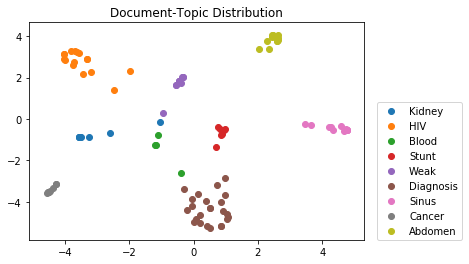

In [36]:
plot_TSNE(sampler.theta(), labels)